In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import re
import json
from pathlib import Path

import pandas as pd
import numpy as np

In [2]:
geodata_dir = Path("../data/geodata-stage/")
apj_dir = Path("../data/apj-rest-ctlg/")

### インスタンスが独立に動作していると考え，インスタンスごと(=hostごと)にDataFrameを作成
- apjのdfには"read", geodataのdfには"write"ラベルを貼る

In [90]:
instance_num = 3

df_dict = {}
for i, data_dir in enumerate([apj_dir, geodata_dir]):
    instance_dict = {j: {} for j in range(1, instance_num + 1)}
    json_paths = data_dir.glob("*.json")
    for path in json_paths:
        with open(path, "r") as f:
            metric = path.name[:-24]
            results = json.load(f)["results"]
            metric_set = set()
            for src_data in results:
                for data in src_data["data"]:
                    metric_set.add(data["metric"])
            for src_data in results:
                if src_data["source"][:10] != "summarizer":
                    for data in src_data["data"]:
                        instance_id = int(re.search('\d', data["tags"]["host"]).group())
                        # jsonのキーは順番保証されていないので念の為ソート
                        tags = [data["tags"][key] for key in sorted(data["tags"].keys()) if key != "host"]
                        key_name = metric
                        # metricフィールドが全て同じならキー名に含めない
                        if len(metric_set) > 1:
                            # metricフィールドの冗長な名前を簡潔化
                            metric_attr = re.findall('^.*\.(.*)$', data['metric'])[0]
                            key_name += f"-{metric_attr}"
                        if len(tags) > 0:
                            key_name += f"-{'-'.join(tags)}"
                        instance_dict[instance_id][key_name] = data["NumericType"]
    for id, instance in instance_dict.items():
        df = pd.DataFrame(instance, dtype="float32")
        df.dropna(inplace=True, axis=0)
        label = "read" if data_dir == apj_dir else "write"
        df["label"] = [label] * len(df)
        df_dict[id - 1 + instance_num * i] = df

### 閾値を徐々に下げて削除していく
これにより相関が非常に高いものを優先的に削除できる

- 特徴量を選択する際は全てのwrite, read intensiveなデータを一緒くたにして相関をみる

In [91]:
# ワークロード間で重複していないメトリックを探索
duplicated_cols = set(df_dict[0].columns)
for tmp_df in df_dict.values():
    duplicated_cols &= set(tmp_df.columns)
    # print(len(tmp_df.columns))

non_duplicated_cols = set()
for tmp_df in df_dict.values():
    non_duplicated_cols |= set(tmp_df.columns) ^ duplicated_cols
print(non_duplicated_cols)

set()


['avg_network_send_received-bytes_sent-eth0',
 'avg_handler-read_first',
 'avg_handler-read_rnd_next',
 'avg_handler-external_lock',
 'avg_handler-delete',
 'avg_threads_connected-mysql_global_status_max_used_connections',
 'avg_cpu-usage_idle',
 'avg_disk_busy-vda2',
 'avg_handler-prepare',
 'avg_threads_connected-mysql_global_status_threads_connected',
 'disk_usage_(data_volume)___binlog_file_total_size-used-vdb',
 'avg_innodb_rows_read-read',
 'avg_innodb_rows_updated-deleted',
 'avg_network_send_received-bytes_recv-eth0',
 'avg_disk_busy-vdb',
 'avg_disk_iops-writes-vda2',
 'avg_cpu-usage_user',
 'avg_handler-read_prev',
 'avg_cpu-usage_softirq',
 'avg_disk_iops-reads-vdb',
 'avg_handler-update',
 'avg_handler-commit',
 'avg_innodb_rows_updated-inserted',
 'avg_memory_usage',
 'avg_handler-read_rnd']


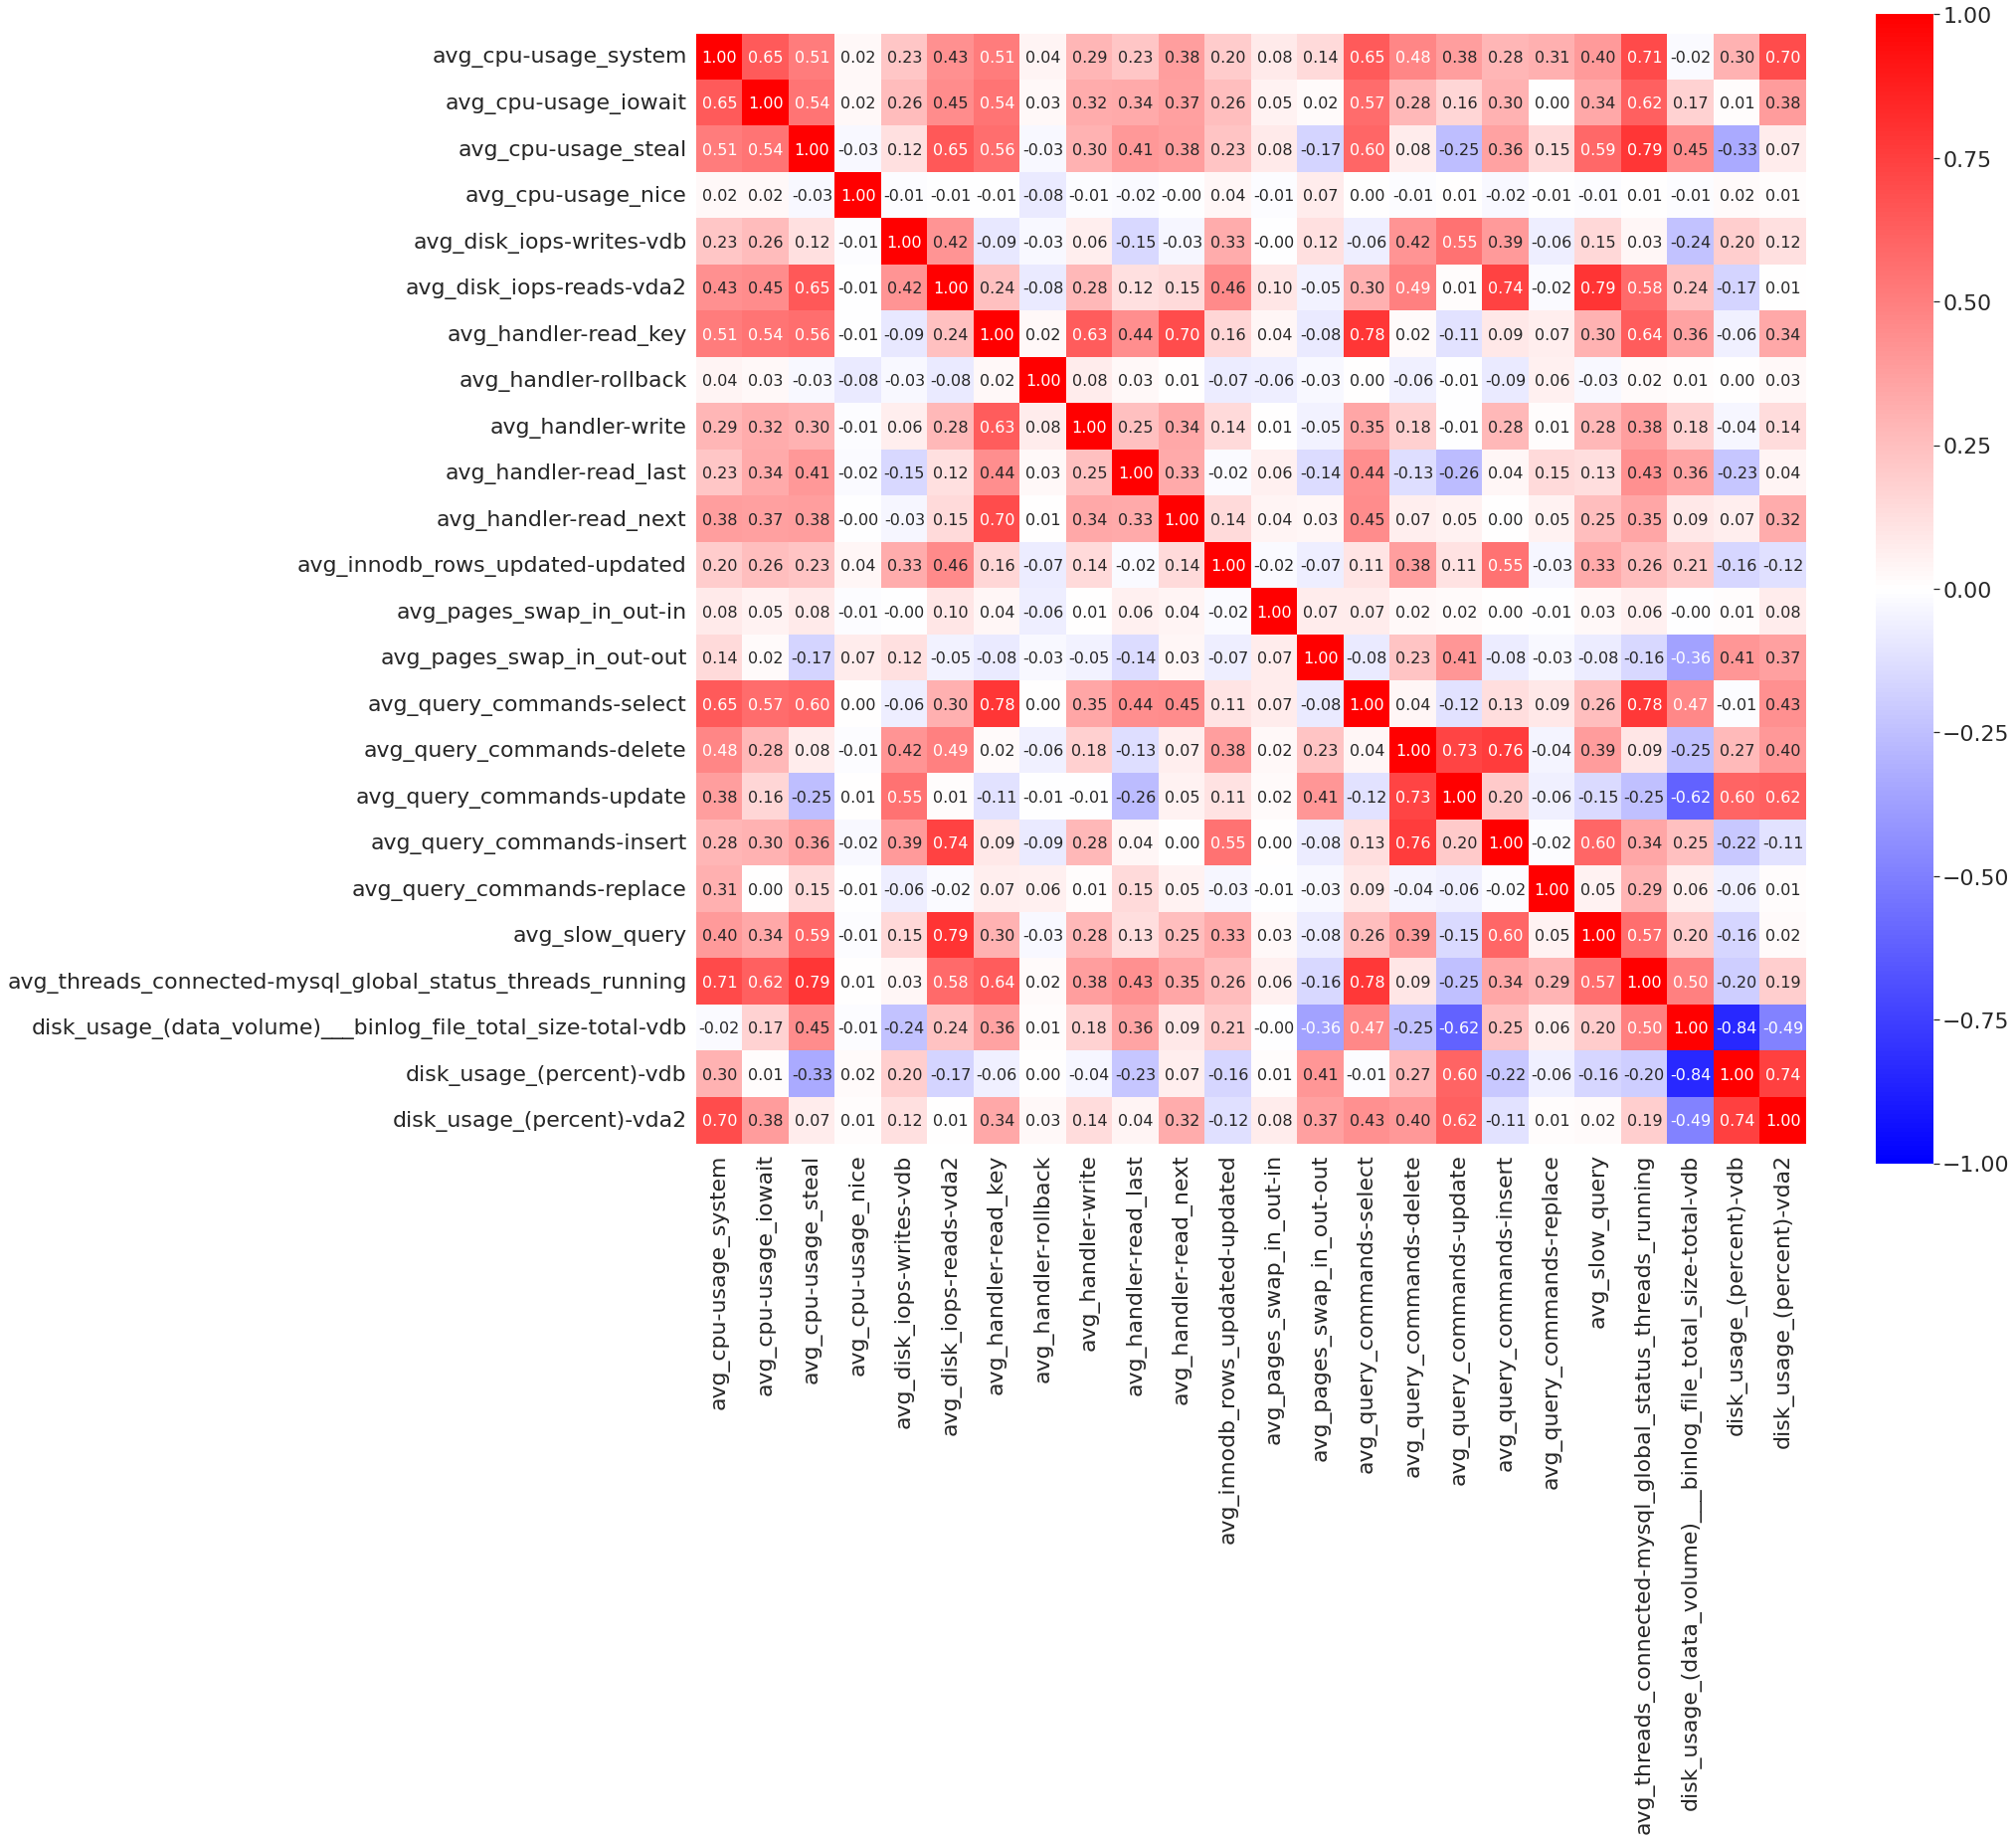

In [95]:
from pprint import pprint

sns.set(font_scale=2)
df = pd.concat(list(df_dict.values()))
df = df.loc[:, df.nunique() != 1] # 値が一定のメトリックを除く
df_selected = df.drop(["label"], axis=1, inplace=False)

labels = df["label"]

del_lim = 25
del_num = 0
ths = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
del_metrics_all = []

for th in ths:
    df_corr = df_selected.corr()
    corr_mat = df_corr.to_numpy()
    cols = df_corr.columns

    # 相関が th 以上 or -th 以下のメトリックを取り出す
    high_corrs_dict = {k: set() for k in cols}
    for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
        if i < j:
            # queryはworkloadを最もよく表しているので，消さないようにする
            if cols[i][:9] != "avg_query":
                high_corrs_dict[cols[i]].add(cols[j])
            if cols[j][:9] != "avg_query":
                high_corrs_dict[cols[j]].add(cols[i])
    del_metrics = []
    while del_num < del_lim:
        # 相関が高いメトリック間の関係数をメトリック別に列挙
        # （メトリックごとの関係数を相関係数の和で代用してもいい）
        del_metric = max(high_corrs_dict.items(), key=lambda item: len(item[1]))[0]
        if len(high_corrs_dict[del_metric]) == 0:
            break
        # keyを削除
        high_corrs_dict.pop(del_metric, None)
        # value(=set)の要素を削除
        for k, v_set in high_corrs_dict.items():
            if del_metric in v_set:
                v_set.discard(del_metric)
        del_metrics.append(del_metric)
        del_num += 1
    del_metrics_all += del_metrics
    df_selected.drop(del_metrics, axis=1, inplace=True)
pprint(del_metrics_all)

plt.figure(figsize=(25, 25))
sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 16}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()

In [34]:
from sklearn.cluster import KMeans

In [96]:
model = KMeans(n_clusters=2, random_state=10)
clusters = model.fit(df_selected)

In [97]:
clusters.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [100]:
labels_pred = clusters.labels_
for label, label_pred in zip(labels, labels_pred):
    if label == "read" and label_pred == 1:
        print("mistake")
    elif label == "write" and label_pred == 0:
        print("mistake")

### TODO
- TPC-Cの擬似データを用いて実データと混ぜてクラスタリング．擬似データと実データが関係なく良い特徴量を選択できているのかを検証
- クラスタ数を3つに分割し，write intensiveなワークロードのうちread用インスタンスとwrite用インスタンスを区別できるのか検証
- 

- Event Spikeなデータを追加する
- もう少し特徴量を削減してみる
- 次元削減を行う